# Self-Normalizing Neural Networks

[Self-normalizing neural networks](https://arxiv.org/abs/1706.02515) (SNNs) are carefully constructed to have zero mean, unit variance activations without an explicit normalization scheme such as batch norm, weight norm, layer norm.

SNN theory is based around analyzing the mapping from the mean and variance of one layer to the next. Let each component of $n$ component vector $x$ be iid distributed from some distribution with mean $\mu$ and variance $\nu$. SNNs exist for any $\mu$ and $\nu$, but to be concrete let $\mu=0$ and $\nu=1$. Let $z = w^T x$ where $\sum_i w_i = \omega$ and $\sum_i w_i^2 = \tau$. As $n$ grows, the central limit theorem states that $z \sim \mathcal{N}(\mu \omega, \sqrt{\nu \tau})$. If the weight vector $w$ is normalized such that $\omega = 0$ and $\tau = 1$, the distribution of $z$ has identical mean and variance to the distribution of each component of $x$, which is a good first step towards normalized activations. For the moment, let's assume $w$ is meets these conditions.

## Scaled Exponential Linear Unit (SELU)

Neural nets need non-linear activation functions to be powerful function approximators. If there existed a non-linear function $s$ that could map $z \sim \mathcal{N}(\mu, \sqrt{\nu})$ to $h$ such that $\mathbf{E}[h] = \mu$, $\text{Var}[h]=\nu$, then it would be possible to non-linearly map $x$ to $z$ to $h$ while preserving the first and second moments.

Conveniently, such a function exists! The authors name it the scaled exponential unit (SELU):

$\begin{align*}
s(x) &= \lambda 
\begin{cases} 
      x & x\geq 0 \\
      \alpha e^x - \alpha & x<0 \\
   \end{cases} \\
s'(x) &= \lambda
\begin{cases} 
      1 & x\geq 0 \\
      \alpha e^x & x<0 \\
   \end{cases}
\end{align*}$

Exponential linear units (ELUs) are a special case of SELU when $\lambda = \alpha = 1$. The authors compute that for $\lambda\approx 1.0507$ and $\alpha \approx 1.6733$, the $s$ preserves mean 0 and variance 1. Let's investigate this.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
scale = 1.0507009873554804934193349852946
alpha = 1.6732632423543772848170429916717
def selu(x):
    return scale * np.where(x >= 0, x, alpha * np.exp(x) - alpha)

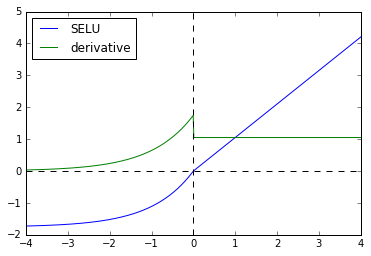

In [3]:
x = np.linspace(-4, 4, 1000)
plt.plot(x, selu(x), label='SELU')
plt.plot(x[1:], np.diff(selu(x)) / np.diff(x), label='derivative')
plt.axhline(0, color='black', linestyle='--'); plt.axvline(0, color='black', linestyle='--')
plt.legend(loc='upper left')
plt.show()

$s$ is continuous, with a minimum value of $-\lambda \alpha$ and no maximum value. $s$ maps positive numbers to positive and negative to negative. $s'$ is not continuous, with maximum value of $\lambda \alpha$ at $x=0$ and a value of $\lambda$ for $x\ge 0$.

Let's visualize how $s$ transforms a distribution.

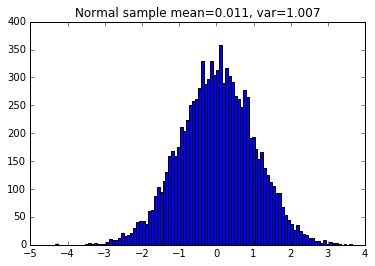

In [4]:
z = np.random.randn(10000)
plt.hist(z, bins=100)
plt.title('Normal sample mean=%.3f, var=%.3f' % (z.mean(), z.var()))
plt.show()

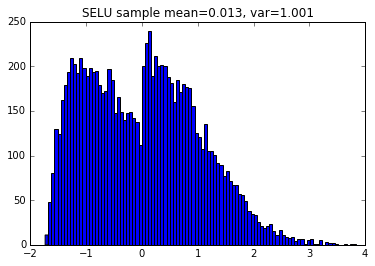

In [5]:
h = selu(z)
plt.hist(h, bins=100)
plt.title('SELU sample mean=%.3f, var=%.3f' % (h.mean(), h.var()))
plt.show()

$h=s(z)$ is clearly not normally distributed despite the normal distribution of $z$. However, SNNs don't claim normally distributed activations, but only that the activations will have 0 mean and unit variance.

Recall the special property of the activation function is to map $z \sim \mathcal{N}(\mu \omega, \sqrt{\nu \tau})$ to $h$ with $\mathbf{E}[h] = 0$ and $\text{Var}[h] = 0$ when $\mu =0,\ \omega=0,\ \nu=1,\ \tau=1$. In practice, none of these equalities will be exact because of issues such as sampling as well as the difficulty of maintaining appropriately normalized weight vectors. The power of SELU comes from the fact that mean and variance in the neighborhood of 1, $\mathbf{E}[h]$ is closer to 0 than $\mathbf{E}{z}$ and $\text{Var}[h]$ is closer to 1 than $\text{Var}[z]$. On the domain of near standard normal distributions, SELU maps to a (non-normal) distribution with closer to zero mean and unit variance.

Stacking layers of nearly normalized matrices followed by SELU activations will lead to activations with moments approaching (0, 1). Each SELU layer is a [contraction](https://en.wikipedia.org/wiki/Banach_fixed-point_theorem) acting on the first two moments of the distribution.

For SELU to move mean and variance closer to 0, 1, it is critical that it is applied to a normal distribution and not just any distribution with appropriate mean and variance. As an example, consider applying the SELU function repeatedly to a normal distribution. If each application contracted the mean and variance, after 10 iterations the mean and variance should be very close to 0, 1. Observe below that is not the case. Thankfully, multiplying by a weight matrix restores the activations to a normal distribution due to central limit theorem.

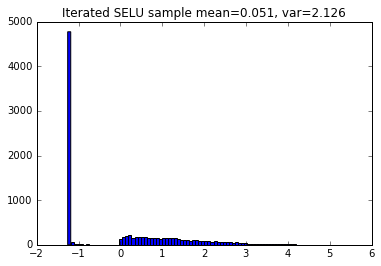

In [6]:
def iter_compose(f, n):
    '''Returns f composed with itself n times.'''
    def g(x):
        for _ in range(n):
            x = f(x)
        return x
    return g

selu10 = iter_compose(selu, 10)
h10 = selu10(z)
plt.hist(h10, bins=100)
plt.title('Iterated SELU sample mean=%.3f, var=%.3f' % (h10.mean(), h10.var()))
plt.show()

Let's observe the moment contraction in action.

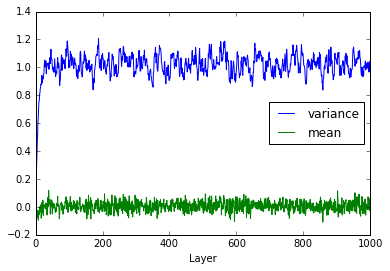

In [7]:
n_dims =  1000
input_mean = 1.1
input_var = .1

x = np.random.randn(n_dims)
x = (x - x.mean()) / x.std()
x = np.sqrt(input_var) * x + input_mean

W = np.random.randn(n_dims, n_dims)
W -= W.mean(axis=1, keepdims=True)
W /= np.sqrt(np.sum(W ** 2, axis=1, keepdims=True))

assert np.allclose(x.mean(), input_mean)
assert np.allclose(x.var(), input_var)
assert np.allclose(W.sum(axis=1), 0)
assert np.allclose(np.sum(W ** 2, axis=1), 1)

activations = [x]
for _ in range(1000):
    h = selu(np.dot(W, activations[-1]))
    activations.append(h)

plt.plot([a.var() for a in activations], label='variance')
plt.plot([a.mean() for a in activations], label='mean')
plt.xlabel('Layer')
plt.legend(loc='center right')
plt.show()

Even with initialization far away from the fixed point, the random SNN normalizes the activations over 1000 layers. This is the key property and benefit of SNNs. Re-running this experiment with different activation functions such as as sigmoid, RELU, or ELU gives dramatically different results.

## Dropout for SNNs

The paper introduces a new type of dropout (called alpha dropout) for use with SNNs. Rather than dropping out to 0 value, they drop out to the minimum SELU value $\alpha' = -\lambda \alpha \approx -1.7580$. To keep the self-normalizing property, the dropout scheme must not alter the mean or variance of the activation. One can solve for an affine function $am(h) + b$ that preserves the moments of $h$ after setting units to $\alpha'$ with probability $1-q$ through mask function $m$.

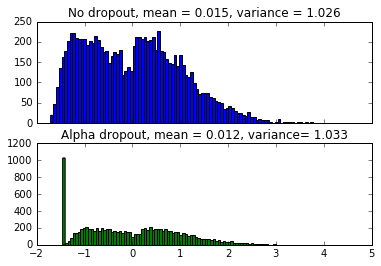

In [8]:
alpha_p = -scale * alpha
def alpha_dropout(h, q):
    '''h is activation, q is keep probability'''
    mask = np.random.binomial(1, q, size=h.shape)
    dropped = mask * h + (1 - mask) * alpha_p
    a = 1. / np.sqrt(q + alpha_p ** 2 * q  * (1 - q))
    b = -a * (1 - q) * alpha_p
    return a * dropped + b
    
keep_prob = .9
x = np.random.randn(10000)
h = selu(x)
hdrop = alpha_dropout(h, keep_prob)

ax1 = plt.subplot(2, 1, 1)
plt.title('No dropout, mean = %.3f, variance = %.3f' % (h.mean(), h.var()))
plt.hist(h, bins=100)
plt.setp(ax1.get_xticklabels(), visible=False)

plt.subplot(2, 1, 2, sharex=ax1)
plt.title('Alpha dropout, mean = %.3f, variance= %.3f' % (hdrop.mean(), hdrop.var()))
plt.hist(hdrop, bins=100, color='green')
plt.show()

The affine linear combination keeps the activation mean and variance steady.

## Final Thoughts

SNNs are a great bit of a math! The name "self-normalizing" is slightly misleading as the activations are non-normal but do have fixed mean and variance.

I wonder if the weight matrices keep the appropriate mean and variance throughout training. If not, could the weights just be normalized at each iteration or something like weight norm be applied?

This seems very applicable to RNNs. The vanilla RNN is $h_t = \sigma(Wh_{t-1} + Vx_t)$. If $h_{t-1}$ and $x_t$ have fixed moments, then $Wh_{t-1}$ and $Vx_t$ are both normal, their sum is normal, and the same math works. However, do you really want fixed mean and variance at every iteration of RNN?

SNNs remove the much loved (or maybe secretly hated?) bias term. They also remove the learnable means and variances included in batch/weight/layer norm. Would there be any benefit to learning different means and variances per unit, where those means and variances would manifest themselves as different $\lambda$ and $\alpha$ parameters? If you wanted to go down this road, would it make sense to set $\lambda$ and $\alpha$ by solving the equations in the paper or just by learning (maybe initialized to the zero mean unit variance standard)?